In [1]:
import argparse
import os
import h5py
import numpy as np

from utils01 import ReadXVGs
from utils01 import GROParser
from utils01 import DiscriptorGenerator

from utils_keras import DNN

os.environ['KMP_DUPLICATE_LIB_OK']='True'


DATASETDIR = "workspace/01-make-datasets"
CUTOFF_RADIUS = 1.0
MASS = {'CA': 12.01100, 'C': 12.01100, 'O': 15.99900, 'N': 14.00700}
DT = 0.002
OUTDIR = "workspace/04-simulate"


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--coords', type=str, help='coord file (.xvg)')
parser.add_argument('--init_time', type=int, default=0, help='init time to start simulation')
parser.add_argument('--gro', type=str, help='specify .gro path if want to include amino infomation into datasets')
parser.add_argument('--dataset', type=str,
                    default=os.path.join(DATASETDIR, 'datasets.hdf5'),
                    help='input datasets')

parser.add_argument('--model', type=int, default=1, help='model number')
parser.add_argument('--weights', type=str, nargs=4, required=True, help='model weights (N, CA, C, O)')

parser.add_argument('--len', type=int, default=5000, help='simulation length')

a = "--coords input/xvg/run1/MainChain-coord.xvg --dataset workspace/01-make-datasets/datasets.hdf5 --gro input/solv_ions_prot.gro --weights workspace/03-learning/N/try000/weights/epoch100.hdf5 workspace/03-learning/CA/try000/weights/epoch100.hdf5 workspace/03-learning/C/try000/weights/epoch100.hdf5 workspace/03-learning/O/try000/weights/epoch100.hdf5 --len 150"
args = parser.parse_args(args=a.split())



In [4]:
groparser = GROParser(args.gro, CUTOFF_RADIUS)
MAINCHAIN = groparser.mainchains
N_ATOMS = groparser.n_atoms
EACH_N_ATOMS = groparser.each_n_atoms
SLICE_INDECES = groparser.slice_indeces
ARRANGED_INDECES = groparser.arranged_indeces
REARRANGED_INDECES = groparser.rearranged_indeces
ADJACENT_INDECES = groparser.adjacent_indeces
AB_INDECES = groparser.ab_indeces
MAX_N_ADJACENT = groparser.max_n_adjacent
ATOM_ALIGN = groparser.atom_align


In [5]:
readxvgs = ReadXVGs(None, None, ARRANGED_INDECES)
coords, forces = readxvgs([["input/xvg/run1/MainChain-coord.xvg"]])
coords = coords.compute()
forces = forces.compute()

init_structs = coords[0:2, ARRANGED_INDECES, :]

In [6]:
discriptor_generator = DiscriptorGenerator(
    None, None,
    MAINCHAIN, N_ATOMS, EACH_N_ATOMS, SLICE_INDECES,
    ADJACENT_INDECES, AB_INDECES, MAX_N_ADJACENT,
    None, None)

# ## read models ## #
dnn = DNN(discriptor_generator.INPUTDIM, None)
Nmodel = dnn(args.model)
Nmodel.load_weights(args.weights[0])
CAmodel = dnn(args.model)
CAmodel.load_weights(args.weights[1])
Cmodel = dnn(args.model)
Cmodel.load_weights(args.weights[2])
Omodel = dnn(args.model)
Omodel.load_weights(args.weights[3])
model = {'N': Nmodel, 'CA': CAmodel, 'C': Cmodel, 'O':Omodel}


In [7]:
# ## normalization values ## #
normalization = {}
with h5py.File("workspace/01-make-datasets/datasets.hdf5", mode='r') as f:
    for atom in MAINCHAIN:
        y_mean, y_std = f[f'/{atom}/normalization'][...]
        normalization[atom] = [y_mean, y_std]


# cal force

In [8]:
# ## cal force ## #
def cal_force(discriptors):
    discriptors = np.tile(discriptors, (N_ATOMS, 1)).reshape(N_ATOMS, -1, 3)
    discriptors = discriptors - discriptors.transpose(1, 0, 2)

    discriptor, rot_matrices = discriptor_generator._descriptor(discriptors)

    forces = np.zeros((N_ATOMS, 3))
    for atom in MAINCHAIN:
        i, j = SLICE_INDECES[atom]
        force = model[atom].predict(discriptor[i:j])
#         y_mean, y_std = normalization[atom]
#         force = np.add(np.multiply(force, y_std), y_mean)
        forces[i:j] = force

    # rotate
    forces = np.array([np.dot(force, np.linalg.inv(rot_matrix)) for force, rot_matrix in zip(forces, rot_matrices)])

    return forces


In [9]:
pred = np.array([cal_force(coord) for coord in coords])
pred.shape

(199, 1235, 3)

In [10]:
for atom in MAINCHAIN:
    i, j = SLICE_INDECES[atom]
    y_mean, y_std = normalization[atom]
    forces[:, i:j, :] = np.divide(np.subtract(forces[:, i:j, :], y_mean), y_std)

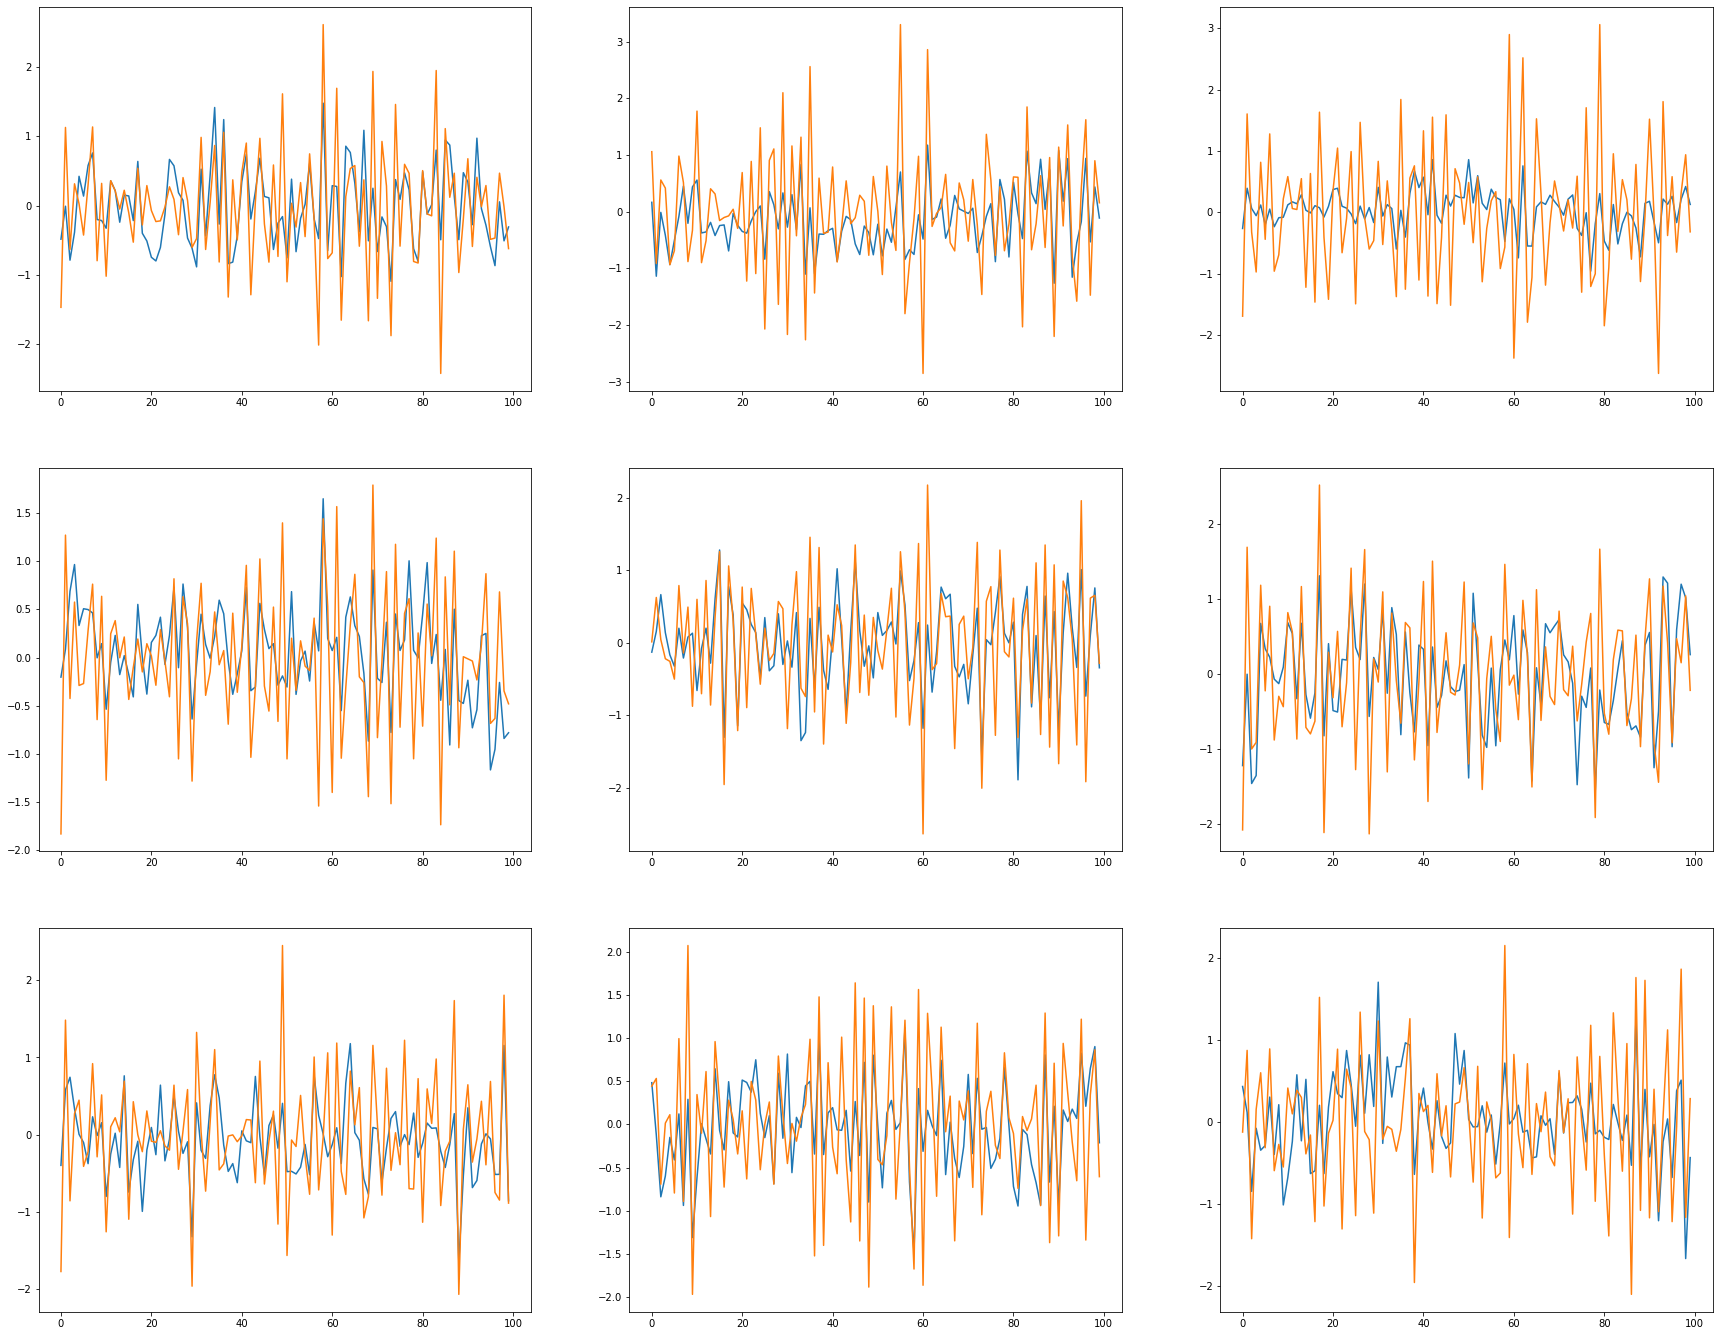

In [11]:
trjlen = 100
atomlist = [0,1,2]

fig = plt.figure(figsize=(30,8*len(atomlist)))
for i, atom in enumerate(atomlist):
    for x in [0,1,2]:
        ax = fig.add_subplot(len(atomlist), 3, x+i*3+1)
        ax.plot(pred[:trjlen, atom, x])
        ax.plot(forces[:trjlen, atom, x])

In [12]:
x = pred-forces

In [13]:
np.mean(np.square(x))

0.6505357076090379